### Import Modules

In [1]:
# To plot learning curve graph
%matplotlib inline
import matplotlib.pyplot as plt

# for pretty print
from pprint import pprint

# for tokenizer
import re

# for word counter in vocabulary dictionary
from collections import Counter

# for checkpoint paths
import os

# for fancy progress bar
from tqdm import tqdm

# TensorFlow
import tensorflow as tf

# for output_projection
from tensorflow.python.layers.core import Dense

# for sampling probability decay
import numpy as np

### Sample training data

In [2]:
# maximum length of input and target sentences including paddings
enc_sentence_length = 10
dec_sentence_length = 10

In [3]:
# Batch_size: 2
input_batches = [
    ['Hi What is your name?', 'Nice to meet you!'],
    ['Which programming language do you use?', 'See you later.'],
    ['Where do you live?', 'What is your major?'],
    ['What do you want to drink?', 'What is your favorite beer?']]

target_batches = [
    ['Hi this is Jaemin.', 'Nice to meet you too!'],
    ['I like Python.', 'Bye Bye.'],
    ['I live in Seoul, South Korea.', 'I study industrial engineering.'],
    ['Beer please!', 'Leffe brown!']]

In [4]:
all_input_sentences = []
for input_batch in input_batches:
    all_input_sentences.extend(input_batch)
    
all_target_sentences = []
for target_batch in target_batches:
    all_target_sentences.extend(target_batch)

# Example
all_input_sentences

['Hi What is your name?',
 'Nice to meet you!',
 'Which programming language do you use?',
 'See you later.',
 'Where do you live?',
 'What is your major?',
 'What do you want to drink?',
 'What is your favorite beer?']

### NLP helper functions

In [5]:
def tokenizer(sentence):
    tokens = re.findall(r"[\w]+|[^\s\w]", sentence)
    return tokens

# Example
tokenizer('Hello world?? "sdfs%@#%')

['Hello', 'world', '?', '?', '"', 'sdfs', '%', '@', '#', '%']

In [6]:
def build_vocab(sentences, is_target=False, max_vocab_size=None):
    word_counter = Counter()
    vocab = dict()
    reverse_vocab = dict()
    
    for sentence in sentences:
        tokens = tokenizer(sentence)
        word_counter.update(tokens)
        
    if max_vocab_size is None:
        max_vocab_size = len(word_counter)
    
    if is_target:
        vocab['_GO'] = 0
        vocab['_PAD'] = 1
        vocab_idx = 2
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
    else:
        vocab['_PAD'] = 0
        vocab_idx = 1
        for key, value in word_counter.most_common(max_vocab_size):
            vocab[key] = vocab_idx
            vocab_idx += 1
            
    for key, value in vocab.items():
        reverse_vocab[value] = key
            
    return vocab, reverse_vocab, max_vocab_size

# Example
pprint(build_vocab(all_input_sentences))
print('\n')
pprint(build_vocab(all_target_sentences))

({'!': 12,
  '.': 19,
  '?': 1,
  'Hi': 8,
  'Nice': 10,
  'See': 17,
  'What': 3,
  'Where': 20,
  'Which': 13,
  '_PAD': 0,
  'beer': 26,
  'do': 6,
  'drink': 24,
  'favorite': 25,
  'is': 4,
  'language': 15,
  'later': 18,
  'live': 21,
  'major': 22,
  'meet': 11,
  'name': 9,
  'programming': 14,
  'to': 7,
  'use': 16,
  'want': 23,
  'you': 2,
  'your': 5},
 {0: '_PAD',
  1: '?',
  2: 'you',
  3: 'What',
  4: 'is',
  5: 'your',
  6: 'do',
  7: 'to',
  8: 'Hi',
  9: 'name',
  10: 'Nice',
  11: 'meet',
  12: '!',
  13: 'Which',
  14: 'programming',
  15: 'language',
  16: 'use',
  17: 'See',
  18: 'later',
  19: '.',
  20: 'Where',
  21: 'live',
  22: 'major',
  23: 'want',
  24: 'drink',
  25: 'favorite',
  26: 'beer'},
 26)


({'!': 2,
  ',': 19,
  '.': 1,
  'Beer': 25,
  'Bye': 4,
  'Hi': 5,
  'I': 3,
  'Jaemin': 8,
  'Korea': 21,
  'Leffe': 27,
  'Nice': 9,
  'Python': 15,
  'Seoul': 18,
  'South': 20,
  '_PAD': 0,
  'brown': 28,
  'engineering': 24,
  'in': 17,
  'industria

In [7]:
enc_vocab, enc_reverse_vocab, enc_vocab_size = build_vocab(all_input_sentences)
dec_vocab, dec_reverse_vocab, dec_vocab_size = build_vocab(all_target_sentences, is_target=True)

print('input vocabulary size:', enc_vocab_size)
print('target vocabulary size:', dec_vocab_size)

input vocabulary size: 26
target vocabulary size: 28


In [8]:
def token2idx(word, vocab):
    return vocab[word]

for token in tokenizer('Nice to meet you!'):
    print(token, token2idx(token, enc_vocab))

Nice 10
to 7
meet 11
you 2
! 12


In [9]:
def sent2idx(sent, vocab=enc_vocab, max_sentence_length=enc_sentence_length, is_target=False):
    tokens = tokenizer(sent)
    current_length = len(tokens)
    pad_length = max_sentence_length - current_length
    if is_target:
        return [0] + [token2idx(token, vocab) for token in tokens] + [1] * pad_length, current_length
    else:
        return [token2idx(token, vocab) for token in tokens] + [0] * pad_length, current_length

# Enc Example
print('Hi What is your name?')
print(sent2idx('Hi What is your name?'))

# Dec Example
print('Hi this is Jaemin.')
print(sent2idx('Hi this is Jaemin.', vocab=dec_vocab, max_sentence_length=dec_sentence_length, is_target=True))

Hi What is your name?
([8, 3, 4, 5, 9, 1, 0, 0, 0, 0], 6)
Hi this is Jaemin.
([0, 6, 7, 8, 9, 2, 1, 1, 1, 1, 1], 5)


In [10]:
def idx2token(idx, reverse_vocab):
    return reverse_vocab[idx]

def idx2sent(indices, reverse_vocab=dec_reverse_vocab):
    return " ".join([idx2token(idx, reverse_vocab) for idx in indices])

### Hyperparameters / Path

In [11]:
class DemoConfig:
    
    # Model
    hidden_size = 30
    enc_emb_size = 30
    dec_emb_size = 30
    cell = tf.contrib.rnn.BasicLSTMCell
    
    # Training
    optimizer = tf.train.RMSPropOptimizer
    n_epoch = 801
    learning_rate = 0.001

    # Sampling Probability
    # with decay => 'Curriculumn Learning'
    sampling_probability_list = np.linspace(
        start=0.0,
        stop=1.0,
        num=n_epoch,
        dtype=np.float32)

    # Checkpoint path
    ckpt_dir = './ckpt_dir/'


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Build Graph

In [12]:
class Seq2SeqModel(object):
    def __init__(self, config, mode='training'):
        assert mode in ['training', 'evaluation', 'inference']
        self.mode = mode

        # Model
        self.hidden_size = config.hidden_size
        self.enc_emb_size = config.enc_emb_size
        self.dec_emb_size = config.dec_emb_size
        self.cell = config.cell
        
        # Training
        self.optimizer = config.optimizer
        self.n_epoch = config.n_epoch
        self.learning_rate = config.learning_rate
        
        # Sampling Probability
        self.sampling_probability_list = config.sampling_probability_list
        
        # Checkpoint path
        self.ckpt_dir = config.ckpt_dir
        
    def add_placeholders(self):
        self.enc_inputs = tf.placeholder(
            tf.int32,
            shape=[None, enc_sentence_length],
            name='input_sentences')

        self.enc_sequence_length = tf.placeholder(
            tf.int32,
            shape=[None,],
            name='input_sequence_length')
        
        if self.mode == 'training':
            self.dec_inputs = tf.placeholder(
                tf.int32,
                shape=[None, dec_sentence_length+1],
                name='target_sentences')

            self.dec_sequence_length = tf.placeholder(
                tf.int32,
                shape=[None,],
                name='target_sequence_length')

            self.sampling_probability = tf.placeholder(
                tf.float32,
                shape=[],
                name='sampling_probability')
            # 0.0 ≤ sampling_probability ≤ 1.0
            # 0.0: no sampling => `ScheduledEmbedidngTrainingHelper` is equivalent to `TrainingHelper`
            # 1.0: always sampling => `ScheduledEmbedidngTrainingHelper` is equivalent to `GreedyEmbeddingHelper`
            # Inceasing sampling over steps => Curriculum Learning
            
    def add_encoder(self):
        with tf.variable_scope('Encoder') as scope:
            with tf.device('/cpu:0'):
                self.enc_Wemb = tf.get_variable('embedding',
                    initializer=tf.random_uniform([enc_vocab_size+1, self.enc_emb_size]),
                    dtype=tf.float32)

            # [Batch_size x enc_sent_len x embedding_size]
            enc_emb_inputs = tf.nn.embedding_lookup(
                self.enc_Wemb, self.enc_inputs, name='emb_inputs')
            enc_cell = self.cell(self.hidden_size)

            # enc_outputs: [batch_size x enc_sent_len x embedding_size]
            # enc_last_state: [batch_size x embedding_size]
            enc_outputs, self.enc_last_state = tf.nn.dynamic_rnn(
                cell=enc_cell,
                inputs=enc_emb_inputs,
                sequence_length=self.enc_sequence_length,
                time_major=False,
                dtype=tf.float32)
            
    def add_decoder(self):
        with tf.variable_scope('Decoder') as scope:
            with tf.device('/cpu:0'):
                self.dec_Wemb = tf.get_variable('embedding',
                    initializer=tf.random_uniform([dec_vocab_size+2, self.dec_emb_size]),
                    dtype=tf.float32)

            dec_cell = self.cell(self.hidden_size)

            # output projection (replacing `OutputProjectionWrapper`)
            output_layer = Dense(dec_vocab_size+2, name='output_projection')
            
            if self.mode == 'training':

                # maximum unrollings in current batch = max(dec_sent_len) + 1(GO symbol)
                max_dec_len = tf.reduce_max(self.dec_sequence_length+1, name='max_dec_len')

                dec_emb_inputs = tf.nn.embedding_lookup(
                    self.dec_Wemb, self.dec_inputs, name='emb_inputs')

                training_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(
                    inputs=dec_emb_inputs,
                    sequence_length=self.dec_sequence_length+1,
                    embedding=self.dec_Wemb,
                    sampling_probability=self.sampling_probability,
                    time_major=False,
                    name='training_helper')                

                training_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=training_helper,
                    initial_state=self.enc_last_state,
                    output_layer=output_layer) 

                train_dec_outputs, train_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(
                    training_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=max_dec_len)
                
                # dec_outputs: collections.namedtuple(rnn_outputs, sample_id)
                # dec_outputs.rnn_output: [batch_size x max(dec_sequence_length) x dec_vocab_size+2], tf.float32
                # dec_outputs.sample_id [batch_size], tf.int32
                
                # logits: [batch_size x max_dec_len x dec_vocab_size+2]
                logits = tf.identity(train_dec_outputs.rnn_output, name='logits')
                
                # targets: [batch_size x max_dec_len x dec_vocab_size+2]
                targets = tf.slice(self.dec_inputs, [0, 0], [-1, max_dec_len], 'targets')
                
                # masks: [batch_size x max_dec_len]
                # => ignore outputs after `dec_senquence_length+1` when calculating loss
                masks = tf.sequence_mask(self.dec_sequence_length+1, max_dec_len, dtype=tf.float32, name='masks')
                
                # Control loss dimensions with `average_across_timesteps` and `average_across_batch`
                # internal: `tf.nn.sparse_softmax_cross_entropy_with_logits`
                self.batch_loss = tf.contrib.seq2seq.sequence_loss(
                    logits=logits,
                    targets=targets,
                    weights=masks,
                    name='batch_loss')
                
                # prediction sample for validation
                # some sample_id are overwritten with '-1's
                self.valid_predictions = tf.argmax(logits, axis=2, name='valid_predictions')
                
                # List of training variables
                # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
            
            elif self.mode == 'inference':

                batch_size = tf.shape(self.enc_inputs)[0:1]
                start_tokens = tf.zeros(batch_size, dtype=tf.int32)

                inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                    embedding=self.dec_Wemb,
                    start_tokens=start_tokens,
                    end_token=1)
                
                inference_decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=dec_cell,
                    helper=inference_helper,
                    initial_state=self.enc_last_state,
                    output_layer=output_layer)
                
                infer_dec_outputs, infer_dec_last_state,_ = tf.contrib.seq2seq.dynamic_decode(
                    inference_decoder,
                    output_time_major=False,
                    impute_finished=True,
                    maximum_iterations=dec_sentence_length)
                
                # [batch_size x dec_sentence_length], tf.int32
                self.predictions = tf.identity(infer_dec_outputs.sample_id, name='predictions')
                # equivalent to tf.argmax(infer_dec_outputs.rnn_output, axis=2, name='predictions')

                # List of training variables
                # self.training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        
    def add_training_op(self):
        self.training_op = self.optimizer(self.learning_rate, name='training_op').minimize(self.batch_loss)
        
    def save(self, sess, var_list=None, save_path=None):
        print(f'Saving model at {save_path}')
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        saver = tf.train.Saver(var_list)
        saver.save(sess, save_path, write_meta_graph=False)
        
    def restore(self, sess, var_list=None, ckpt_path=None):
        if hasattr(self, 'training_variables'):
            var_list = self.training_variables
        self.restorer = tf.train.Saver(var_list)
        self.restorer.restore(sess, ckpt_path)
        print('Restore Finished!')
        
    def summary(self):
        summary_writer = tf.summary.FileWriter(
            logdir=self.ckpt_dir,
            graph=tf.get_default_graph())
        
    def build(self):
        self.add_placeholders()
        self.add_encoder()
        self.add_decoder()
        
    def train(self, sess, data, from_scratch=False, load_ckpt=None, save_path=None):
        
        # Restore Checkpoint
        if from_scratch is False and os.path.isfile(load_ckpt):
            self.restore(sess, load_ckpt)
    
        # Add Optimizer to current graph
        self.add_training_op()
        
        sess.run(tf.global_variables_initializer())
        
        input_batches, target_batches = data
        loss_history = []
        
        for epoch in tqdm(range(self.n_epoch)):

            all_preds = []
            epoch_loss = 0
            for input_batch, target_batch in zip(input_batches, target_batches):
                input_batch_tokens = []
                target_batch_tokens = []
                input_batch_sent_lens = []
                target_batch_sent_lens = []

                for input_sent in input_batch:
                    tokens, sent_len = sent2idx(input_sent)
                    input_batch_tokens.append(tokens)
                    input_batch_sent_lens.append(sent_len)

                for target_sent in target_batch:
                    tokens, sent_len = sent2idx(target_sent,
                                 vocab=dec_vocab,
                                 max_sentence_length=dec_sentence_length,
                                 is_target=True)
                    target_batch_tokens.append(tokens)
                    target_batch_sent_lens.append(sent_len)
       
                # Evaluate 3 ops in the graph
                # => valid_predictions, loss, training_op(optimzier)
                batch_valid_preds, batch_loss, _ = sess.run(
                    [self.valid_predictions, self.batch_loss, self.training_op],
                    feed_dict={
                        self.enc_inputs: input_batch_tokens,
                        self.enc_sequence_length: input_batch_sent_lens,
                        self.dec_inputs: target_batch_tokens,
                        self.dec_sequence_length: target_batch_sent_lens,
                        self.sampling_probability: self.sampling_probability_list[epoch]
                    }
                )
                # loss_history.append(batch_loss)
                epoch_loss += batch_loss
                all_preds.append(batch_valid_preds)
                
            loss_history.append(epoch_loss)
                        
            # Logging every 400 epochs
            if epoch % 400 == 0:
                print('Epoch', epoch)
                print(f'Sampling probability: {self.sampling_probability_list[epoch]:.3f}')
                for input_batch, target_batch, batch_preds in zip(input_batches, target_batches, all_preds):
                    for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
                        print(f'\tInput: {input_sent}')
                        print(f'\tPrediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
                        print(f'\tTarget: {target_sent}\n')
                print(f'\tepoch loss: {epoch_loss:.2f}\n')
                
        if save_path:
            self.save(sess, save_path=save_path)

        return loss_history
    
    def inference(self, sess, data, load_ckpt):

        self.restore(sess, ckpt_path=load_ckpt)
                
        input_batch, target_batch = data
        
        batch_preds = []
        batch_tokens = []
        batch_sent_lens = []

        for input_sent in input_batch:
            tokens, sent_len = sent2idx(input_sent)
            batch_tokens.append(tokens)
            batch_sent_lens.append(sent_len)
            
        batch_preds = sess.run(
            self.predictions,
            feed_dict={
                self.enc_inputs: batch_tokens,
                self.enc_sequence_length: batch_sent_lens,
            })

        for input_sent, target_sent, pred in zip(input_batch, target_batch, batch_preds):
            print('Input:', input_sent)
            print('Prediction:', idx2sent(pred, reverse_vocab=dec_reverse_vocab))
            print('Target:', target_sent, '\n')

### Check if models are sucessufully built

In [13]:
tf.reset_default_graph()
config = DemoConfig()
model = Seq2SeqModel(config, mode='training')
model.build()
# model.summary()
print('Training model built!')

Training model built!


In [14]:
tf.reset_default_graph()
config = DemoConfig()
model = Seq2SeqModel(config, mode='inference')
model.build()
# model.summary()
print('Inference model built!')

Inference model built!


### Train model

In [15]:
tf.reset_default_graph()     
with tf.Session() as sess:
    config = DemoConfig()
    model = Seq2SeqModel(config, mode='training')
    model.build()
    data = (input_batches, target_batches)
    loss_history = model.train(sess, data, from_scratch=True, save_path=model.ckpt_dir+f'epoch_{model.n_epoch}_sampling')

/usr/local/python36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
  1%|          | 6/801 [00:00<05:16,  2.51it/s]

Epoch 0
Sampling probability: 0.000
	Input: Hi What is your name?
	Prediction: brown brown too too too too _GO
	Target: Hi this is Jaemin.

	Input: Nice to meet you!
	Prediction: to too too too too too too
	Target: Nice to meet you too!

	Input: Which programming language do you use?
	Prediction: brown too too too too
	Target: I like Python.

	Input: See you later.
	Prediction: too too too too _GO
	Target: Bye Bye.

	Input: Where do you live?
	Prediction: too too too too too too too too too
	Target: I live in Seoul, South Korea.

	Input: What is your major?
	Prediction: too too too too too too _GO _GO _GO
	Target: I study industrial engineering.

	Input: What do you want to drink?
	Prediction: Hi brown too too
	Target: Beer please!

	Input: What is your favorite beer?
	Prediction: Hi too too too
	Target: Leffe brown!

	epoch loss: 13.89



 51%|█████     | 405/801 [00:10<00:09, 41.11it/s]

Epoch 400
Sampling probability: 0.500
	Input: Hi What is your name?
	Prediction: _GO Hi this is Jaemin . _GO
	Target: Hi this is Jaemin.

	Input: Nice to meet you!
	Prediction: _GO Nice to meet you too !
	Target: Nice to meet you too!

	Input: Which programming language do you use?
	Prediction: _GO I like Python .
	Target: I like Python.

	Input: See you later.
	Prediction: _GO Bye Bye . _GO
	Target: Bye Bye.

	Input: Where do you live?
	Prediction: _GO I live in Seoul , South Korea .
	Target: I live in Seoul, South Korea.

	Input: What is your major?
	Prediction: _GO I study industrial engineering . _GO _GO _GO
	Target: I study industrial engineering.

	Input: What do you want to drink?
	Prediction: _GO Beer please !
	Target: Beer please!

	Input: What is your favorite beer?
	Prediction: _GO Leffe brown !
	Target: Leffe brown!

	epoch loss: 0.07



100%|██████████| 801/801 [00:20<00:00, 43.85it/s]


Epoch 800
Sampling probability: 1.000
	Input: Hi What is your name?
	Prediction: _GO Hi this is Jaemin . _GO
	Target: Hi this is Jaemin.

	Input: Nice to meet you!
	Prediction: _GO Nice to meet you too !
	Target: Nice to meet you too!

	Input: Which programming language do you use?
	Prediction: _GO I like Python .
	Target: I like Python.

	Input: See you later.
	Prediction: _GO Bye Bye . _GO
	Target: Bye Bye.

	Input: Where do you live?
	Prediction: _GO I live in Seoul , South Korea .
	Target: I live in Seoul, South Korea.

	Input: What is your major?
	Prediction: _GO I study industrial engineering . _GO _GO _GO
	Target: I study industrial engineering.

	Input: What do you want to drink?
	Prediction: _GO Beer please !
	Target: Beer please!

	Input: What is your favorite beer?
	Prediction: _GO Leffe brown !
	Target: Leffe brown!

	epoch loss: 0.00

Saving model at ./ckpt_dir/epoch_801_sampling


### Learning Curve

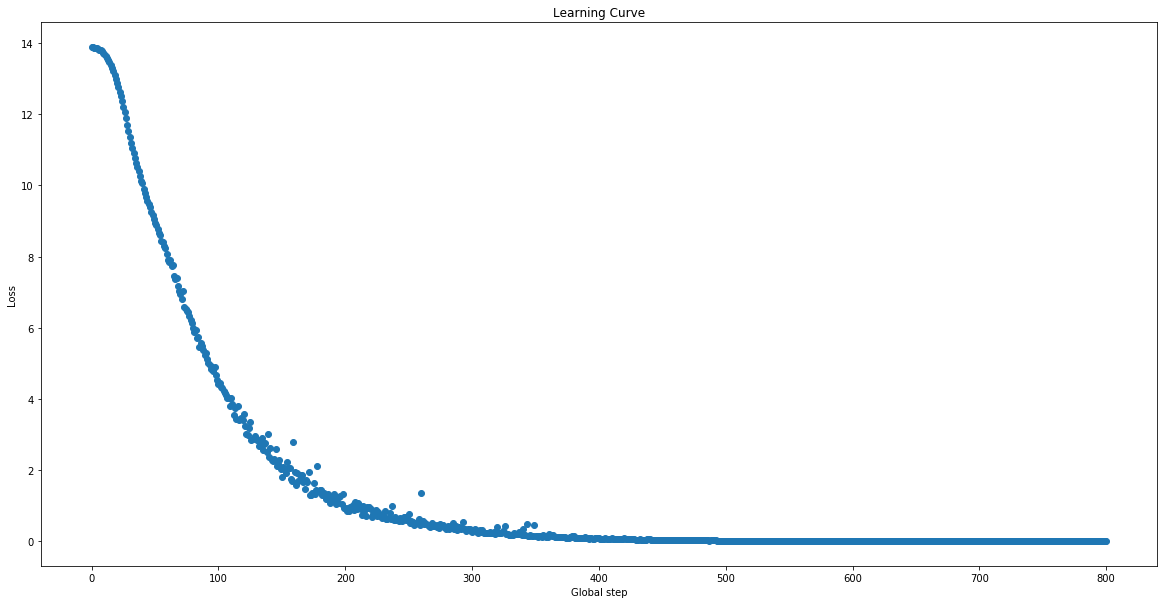

In [16]:
plt.figure(figsize=(20, 10))
plt.scatter(range(model.n_epoch), loss_history)
plt.title('Learning Curve')
plt.xlabel('Global step')
plt.ylabel('Loss')
plt.show()

### Inference

In [17]:
tf.reset_default_graph()
with tf.Session() as sess:
    config = DemoConfig()
    model = Seq2SeqModel(config, mode='inference')
    model.build()
    for input_batch, target_batch in zip(input_batches, target_batches):
        data = (input_batch, target_batch)
        model.inference(sess, data, load_ckpt=model.ckpt_dir+f'epoch_{model.n_epoch}_sampling')

Restore Finished!
Input: Hi What is your name?
Prediction: _GO Hi this is Jaemin . . . . .
Target: Hi this is Jaemin. 

Input: Nice to meet you!
Prediction: _GO Nice to meet you too ! ! ! !
Target: Nice to meet you too! 

Restore Finished!
Input: Which programming language do you use?
Prediction: _GO I like Python . . . . . .
Target: I like Python. 

Input: See you later.
Prediction: _GO Bye Bye . . . . . . .
Target: Bye Bye. 

Restore Finished!
Input: Where do you live?
Prediction: _GO I live in Seoul , South Korea . .
Target: I live in Seoul, South Korea. 

Input: What is your major?
Prediction: _GO I study industrial engineering . . . . .
Target: I study industrial engineering. 

Restore Finished!
Input: What do you want to drink?
Prediction: _GO Beer please ! ! ! ! ! ! !
Target: Beer please! 

Input: What is your favorite beer?
Prediction: _GO Leffe brown ! ! ! ! ! ! !
Target: Leffe brown! 



## Better performance than without scheduled sampling!
- A word of caution: http://www.inference.vc/scheduled-sampling-for-rnns-scoring-rule-interpretation/